In [1]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import Dense 
from keras.models import Sequential
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

2022-10-18 15:29:19.696279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/view

In [2]:
train_df = pd.read_csv('train_1Dy.csv',nrows=500000)
test_df = pd.read_csv('test_1Dy.csv',nrows=5000)

In [3]:
X_train = train_df.drop(columns=['y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-midplane','cotBeta']).values

y_train = train_df['y-midplane'].values
y_test = test_df['y-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
maxval = 1e9
minval = 1e-9

pi = 3.14159265359
sqrtPiOn2 = 1.25331413732
sqrt2 = 1.41421356237

def double_crystalball_norm(mu, sigma, alphaL, nL, alphaR, nR):
    LN_top = tf.math.exp(-0.5*alphaL*alphaL)*nL
    LN_bottom = tf.maximum(alphaL*(nL-1),minval)

    RN_top = tf.math.exp(-0.5*alphaR*alphaR)*nR
    RN_bottom = tf.maximum(alphaR*(nR-1),minval)

    CN = sqrtPiOn2 * (tf.math.erf(alphaL/sqrt2) + tf.math.erf(alphaR/sqrt2))
    
    den = sigma*(LN_top/LN_bottom + RN_top/RN_bottom + CN)

    return tf.clip_by_value(1./den,minval,maxval)

def dcsb(y, p):
       
    mu     = tf.gather(params=p, indices=[0], axis=1)
    sigma  = tf.maximum(tf.gather(params=p, indices=[1], axis=1),minval)
    alphaR = tf.maximum(tf.gather(params=p, indices=[2], axis=1),minval)
    alphaL = tf.maximum(tf.gather(params=p, indices=[3], axis=1),minval)
    nR     = 2#tf.maximum(tf.gather(params=p, indices=[4], axis=1),minval)
    nL     = 2#tf.maximum(tf.gather(params=p, indices=[5], axis=1),minval)
    
    t = 1.0*(y-mu)/sigma
    RL = 1.0*nL/alphaL
    RR = 1.0*nR/alphaR
    
    norm = double_crystalball_norm(mu, sigma, alphaL, nL, alphaR, nR)
    
    term1Left  = tf.maximum((1/RL)*(RL - alphaL - t),minval)
    normLeft   = tf.math.exp(-0.5*alphaL*alphaL)
    term1Right = tf.maximum((1/RR)*(RR - alphaR + t),minval)
    normRight  = tf.math.exp(-0.5*alphaR*alphaR)
    
    # pow function cares if you ask it to do 0 to a negative power
    termLeft  = norm*normLeft*tf.math.pow(term1Left,-1*nL)
    termRight = norm*normRight*tf.math.pow(term1Right,-1*nR)
    termMiddle = tf.math.exp(-0.5*t*t)
    
    termLeft   = tf.math.multiply_no_nan(termLeft, tf.cast(t<-1*alphaL,tf.float32))
    termRight  = tf.math.multiply_no_nan(termRight, tf.cast(t>alphaR,tf.float32))
    termMiddle = tf.math.multiply_no_nan(termMiddle, tf.cast(t>=-1*alphaL,tf.float32)*tf.cast(t<=alphaR,tf.float32))
    
    
    inside = tf.clip_by_value(norm*(termLeft+termMiddle+termRight),minval,1)
    
    NLL = -1.0*tf.math.log(inside)
    
    return tf.keras.backend.sum(NLL,axis=1)

model = Sequential()
model.add(Dense(48, input_shape=(13,), activation='relu')) # Add an input shape! (features,)
model.add(Dense(4, activation='linear'))
model.summary() 

model.compile(optimizer='Adam', 
              loss=dcsb)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 196       
Total params: 868
Trainable params: 868
Non-trainable params: 0
_________________________________________________________________


2022-10-18 15:29:26.889588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/views/LCG_101/

In [6]:
es = EarlyStopping(patience=5)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

2022-10-18 15:29:27.089589: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-18 15:29:27.091819: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000000000 Hz


Epoch 1/80
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
6250/6250 [==============================] - 14s 2ms/step - loss: 3.0016 - val_loss: 2.4589
Epoch 2/80
6250/6250 [==============================] - 11s 2ms/step - loss: 2.0887 - val_loss: 1.9658
Epoch 3/80
6250/6250 [==============================] - 11s 2ms/step - loss: 1.8285 - val_loss: 1.7206
Epoch 4/80
6250/6250 [==============================] - 11s 2ms/step - loss: 1.6646 - val_loss: 1.5671
Epoch 5/80
6250/6250 [==============================] - 11s 2ms/step - loss: 1.5648 - val_loss: 1.5035
Epoch 6/80
6250/6250 [==============================] - 10s 2ms/step - loss: 1.5284 - val_loss: 1.4593
Epoch 7/80
6250/6250 [==============================] - 11s 2ms/step - loss: 1.4507 - val_loss: 1.4058
Epoch 8/80
6250/6250 [==============================] - 11s 2ms/step - loss: 1.4285 - val_loss: 1.3966
Epoch 9/80
6250/6250 [================

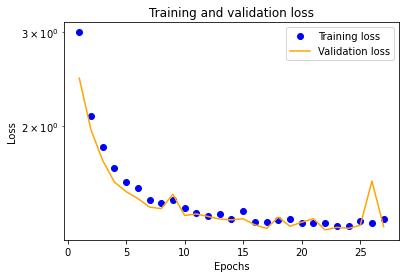

In [7]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
#plt.savefig('/home/jieun201/fullprecision400e_yprofile/loss.png')

In [8]:
#model.save('models_1Dy/gausstest.keras')

In [9]:
p_test = model.predict(X_test)
np.savetxt("test_1DyDCSB.csv", p_test, delimiter=",")

In [10]:
residuals = y_test - p_test[:,0]

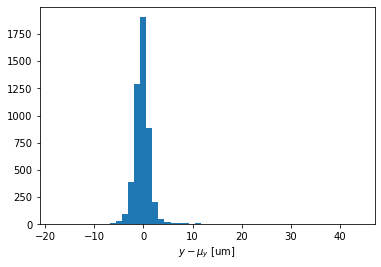

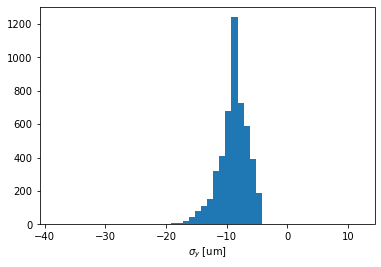

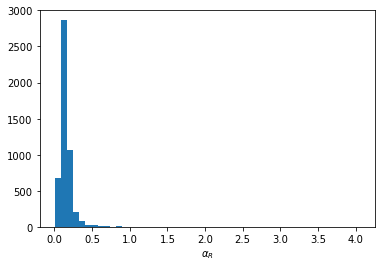

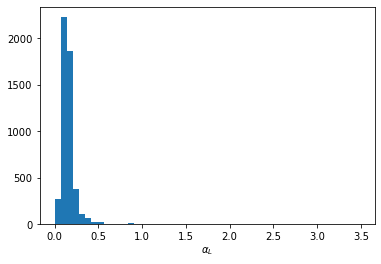

IndexError: index 4 is out of bounds for axis 1 with size 4

In [11]:
plt.hist(residuals,bins=50)
plt.xlabel(r'$y-\mu_y$ [um]')
plt.show()

plt.hist(p_test[:,1],bins=50);
plt.xlabel(r'$\sigma_y$ [um]')
plt.show()

plt.hist(abs(p_test[:,2]),bins=50);
plt.xlabel(r'$\alpha_R$')
plt.show()

plt.hist(abs(p_test[:,3]),bins=50);
plt.xlabel(r'$\alpha_L$')
plt.show()

plt.hist(abs(p_test[:,4]),bins=50);
plt.xlabel(r'$n_R$')
plt.show()

plt.hist(abs(p_test[:,5]),bins=50);
plt.xlabel(r'$n_L$')
plt.show()

Text(0, 0.5, 'Predicted $y$ [um]')

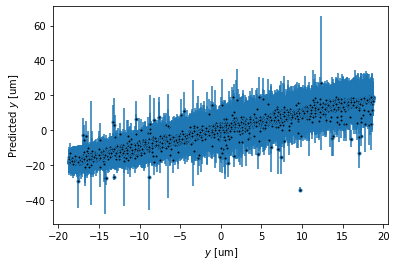

In [12]:
plt.errorbar(x=y_test,y=p_test[:,0],yerr=p_test[:,1],linestyle='',marker='.',markerfacecolor='black')
plt.xlabel(r'$y$ [um]')
plt.ylabel(r'Predicted $y$ [um]')

Text(0, 0.5, '$\\sigma_y$ [um]')

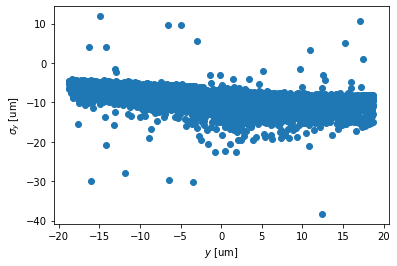

In [13]:
plt.scatter(y_test,p_test[:,1])
plt.xlabel(r'$y$ [um]')
plt.ylabel(r'$\sigma_y$ [um]')

In [14]:
pulls = residuals/p_test[:,1]

Text(0.5, 0, 'pull')

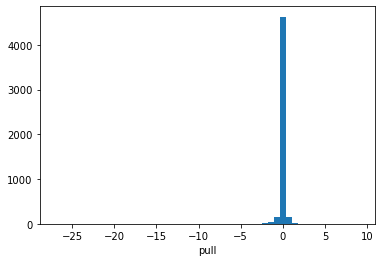

In [15]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [16]:
print(np.mean(pulls),np.std(pulls))

0.017921371126085092 0.5090315661038509


In [17]:
y_train

array([  9.94908375,   5.11272419,  -4.56793761, ..., -18.29209068,
        -7.53264584,  17.31724705])

In [ ]:
tf.print(tf.math.pow(0.,-1))